In [2]:
import pandas as pd
import numpy as np

import re

from py2neo import authenticate, Graph, Node, Relationship


import os
import csv
import pickle

from time import sleep
from timeit import default_timer as timer
from datetime import datetime

from IPython.display import display, HTML

# custom general helper functions for this project
import custom_utils as cu
import importlib


In [3]:
from collections import defaultdict

In [4]:
# reload imports as needed
importlib.reload(cu);

In [33]:
# set up Pandas options
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.2f}'.format

In [62]:
pd.options.display.max_colwidth = 100

In [7]:
n4j_cred = cu.read_n4jpass()

# set up authentication parameters
authenticate("localhost:7474", n4j_cred["user"], n4j_cred["password"])

# connect to authenticated graph database
graph = Graph("http://localhost:7474/db/data/")

# test query
r = graph.data('CALL db.indexes;')
pd.DataFrame(r)

,description,failureMessage,id,indexName,progress,properties,provider,state,tokenNames,type
0,INDEX ON :Article(title),,1,index_1,100.00,[title],"{'key': 'native-btree', 'version': '1.0'}",ONLINE,[Article],node_unique_property


In [8]:
# get a listing of nodes, their partitions, communities and incoming traffic
start_time = timer()
q = """
    MATCH (a:Article)
    WHERE exists(a.louvain_community)
    RETURN 
        a.title as title,
        a.louvain_community as louvain_community, 
            
        a.external_search_traffic as external_search_traffic,
        a.external_website_traffic as external_website_traffic,
        a.unknown_external_traffic as unknown_external_traffic,
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic,
        
        a.link_in_traffic as link_in_traffic,
        a.search_in_traffic as search_in_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page
    ORDER BY external_search_traffic IS NOT NULL desc, external_search_traffic desc;
    """
r = graph.data(q)
nodes_for_deep_wiki = pd.DataFrame(r)

print("Number of articles:",len(nodes_for_deep_wiki))

cu.printRunTime(start_time)

Number of articles: 2729767


Runtime: 5.74 min



In [28]:
nodes_for_deep_wiki.fillna(0, inplace=True)

In [29]:
nodes_for_deep_wiki["total_external_visits"] = (  nodes_for_deep_wiki.external_website_traffic
                                                + nodes_for_deep_wiki.unknown_external_traffic
                                                + nodes_for_deep_wiki.external_search_traffic
                                                + nodes_for_deep_wiki.empty_referer_traffic
                                                + nodes_for_deep_wiki.other_wikimedia_traffic
                                               )

nodes_for_deep_wiki["total_internal_visits"] = (  nodes_for_deep_wiki.search_in_traffic
                                                + nodes_for_deep_wiki.search_traffic_from_main_page
                                                + nodes_for_deep_wiki.link_in_traffic
                                               )

nodes_for_deep_wiki.head()

,empty_referer_traffic,external_search_traffic,external_website_traffic,link_in_traffic,louvain_community,other_wikimedia_traffic,search_in_traffic,search_traffic_from_main_page,title,total_external_visits,total_internal_visits,unknown_external_traffic
0,804462.00,4576854.00,38972.00,1108189.00,3,109536.00,5630.00,220667.00,George_H._W._Bush,5556953.00,1334486.00,27129.00
1,990366.00,3538068.00,9764.00,639353.00,4,45797.00,6451.00,15162.00,Jason_Momoa,4600295.00,660966.00,16300.00
2,793408.00,3475113.00,19564.00,223635.00,9,44383.00,23563.00,13367.00,2.0_(film),4514826.00,260565.00,182358.00
3,586351.00,3251996.00,7054.00,682992.00,4,127234.00,10416.00,33848.00,Bird_Box_(film),3983082.00,727256.00,10447.00
4,492341152.00,3020671.00,677294.00,31170.00,1,8826536.00,0.00,0.00,Main_Page,504947300.00,31170.00,81647.00


In [30]:
nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0][:10]

,empty_referer_traffic,external_search_traffic,external_website_traffic,link_in_traffic,louvain_community,other_wikimedia_traffic,search_in_traffic,search_traffic_from_main_page,title,total_external_visits,total_internal_visits,unknown_external_traffic
2708842,0.00,0.00,0.00,0.00,7,0.00,0.00,0.00,Myktybek_Abdyldayev,0.00,0.00,0.00
2708843,0.00,0.00,0.00,0.00,3,0.00,0.00,0.00,Stockholm_attack,0.00,0.00,0.00
2708844,0.00,0.00,0.00,34.00,13,0.00,0.00,0.00,Strategic_Command_(disambiguation),0.00,34.00,0.00
2708845,0.00,0.00,0.00,0.00,1,0.00,0.00,0.00,"Orders,_decorations,_and_medals_of_Turkmenistan",0.00,0.00,0.00
2708846,0.00,0.00,0.00,108.00,3,0.00,0.00,0.00,"John_Lyon,_4th_Lord_Glamis",0.00,108.00,0.00
2708847,0.00,0.00,0.00,39.00,17,0.00,0.00,0.00,United_Front_(China)_(disambiguation),0.00,39.00,0.00
2708848,0.00,0.00,0.00,14.00,4,0.00,0.00,0.00,Frank_Mancuso_(disambiguation),0.00,14.00,0.00
2708849,0.00,0.00,0.00,29.00,2,0.00,0.00,0.00,Tilsit_(disambiguation),0.00,29.00,0.00
2708850,0.00,0.00,0.00,43.00,4,0.00,0.00,0.00,Dramarama_(disambiguation),0.00,43.00,0.00
2708851,0.00,0.00,0.00,0.00,22,0.00,0.00,0.00,V50,0.00,0.00,0.00


In [173]:
community_deepWiki_stats = nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0] \
    .groupby("louvain_community")[["title"]].count()
community_deepWiki_stats.columns = ["deep_wiki_articles_count"]

community_deepWiki_stats[:5]

,deep_wiki_articles_count
louvain_community,
0,248
1,1099
2,2423
3,3860
4,1020


In [154]:
len(community_deepWiki_stats)

293

In [174]:
pd.options.display.float_format = '{:.8f}'.format

In [175]:
community_deepWiki_stats["articles_count"] = nodes_for_deep_wiki.groupby("louvain_community")["title"].count()
community_deepWiki_stats["deep_wiki_articles_proportion"] = \
    community_deepWiki_stats.deep_wiki_articles_count / community_deepWiki_stats.articles_count


community_deepWiki_stats["deep_wiki_internal_visits"] = \
    nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0] \
    .groupby("louvain_community")["total_internal_visits"] \
    .sum().astype("int64")
community_deepWiki_stats["total_internal_visits"] = \
    nodes_for_deep_wiki.groupby("louvain_community")["total_internal_visits"].sum().astype("int64")
community_deepWiki_stats["deep_wiki_internal_visits_proportion"] = \
    community_deepWiki_stats.deep_wiki_internal_visits / community_deepWiki_stats.total_internal_visits

    
    
community_deepWiki_stats["deep_wiki_link_in_traffic"] = \
    nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0] \
    .groupby("louvain_community")["link_in_traffic"] \
    .sum().astype("int64")
community_deepWiki_stats["link_in_traffic"] = nodes_for_deep_wiki.groupby("louvain_community")["link_in_traffic"] \
                                              .sum().astype("int64")
community_deepWiki_stats["deep_wiki_link_in_traffic_proportion"] = \
    community_deepWiki_stats.deep_wiki_link_in_traffic / community_deepWiki_stats.link_in_traffic

    

community_deepWiki_stats["deep_wiki_search_in_traffic"] = \
    nodes_for_deep_wiki[nodes_for_deep_wiki.total_external_visits == 0] \
    .groupby("louvain_community")["search_in_traffic"] \
    .sum().astype("int64")
community_deepWiki_stats["search_in_traffic"] = nodes_for_deep_wiki.groupby("louvain_community")["search_in_traffic"] \
                                              .sum().astype("int64")
community_deepWiki_stats["deep_wiki_search_in_traffic_proportion"] = \
    community_deepWiki_stats.deep_wiki_search_in_traffic / community_deepWiki_stats.search_in_traffic

    
    
community_deepWiki_stats.head()

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion
louvain_community,,,,,,,,,,,,
0,248,29397,0.00843623,3435,5306439,0.00064733,3414,5057107,0.00067509,21,29778,0.00070522
1,1099,218001,0.00504126,19950,101941984,0.00019570,19691,95420595,0.00020636,259,1056534,0.00024514
2,2423,209065,0.01158970,39438,100235624,0.00039345,38916,96546076,0.00040308,522,1568306,0.00033284
3,3860,507642,0.00760378,64629,339915502,0.00019013,62693,329625267,0.00019019,1916,4188154,0.00045748
4,1020,267541,0.00381250,18366,472694667,0.00003885,18132,461475849,0.00003929,234,3938984,0.00005941


In [103]:
community_deepWiki_stats.describe()

/home/arinai/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion
count,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,293.00000000,79.00000000
mean,71.41638225,9264.49488055,0.12533002,1233.52901024,6034239.98634812,0.08369043,1212.45051195,5859586.15358362,0.08354263,19.91808874,63954.11604096,0.02066294
std,359.27948827,46608.41982077,0.11026480,6258.85888791,37637817.34217964,0.11221609,6139.12717474,36625286.20176264,0.11261909,130.41729697,375719.72973362,0.13163346
min,1.00000000,3.00000000,0.00151883,0.00000000,46.00000000,0.00000000,0.00000000,46.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,1.00000000,7.00000000,0.04545455,13.00000000,186.00000000,0.01059536,13.00000000,185.00000000,0.00961538,0.00000000,0.00000000,nan
50%,1.00000000,13.00000000,0.10000000,21.00000000,404.00000000,0.04411765,21.00000000,403.00000000,0.04333333,0.00000000,0.00000000,nan
75%,3.00000000,35.00000000,0.16666667,47.00000000,1869.00000000,0.11538462,47.00000000,1824.00000000,0.11475410,0.00000000,11.00000000,nan
max,3860.00000000,507642.00000000,0.60000000,64629.00000000,472694667.00000000,0.81967213,62693.00000000,461475849.00000000,0.81967213,1916.00000000,4188154.00000000,1.00000000


In [66]:
# unpickle
with open("pickles/en_1218_louvain_community_topics_dict.pkl", 'rb') as picklefile: 
    community_topics_dict = pickle.load(picklefile)

community_topics_dict[22]["topic_words"][:5]

['grand', 'prix', 'championship', 'seri', 'engin']

In [67]:
community_ids = community_deepWiki_stats.index.values
for i in community_ids:
    community_deepWiki_stats.at[i, "topic_words"] = " ".join(community_topics_dict[i]["topic_words"])
       

In [68]:
community_deepWiki_stats[:10]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,
0,248,29397,0.00843623,3414,5057107,0.00067509,21,29778,0.00070522,station railway class line rail metro list park train transport british london south road tram c...
1,1099,218001,0.00504126,19691,95420595,0.00020636,259,1056534,0.00024514,list disambigu softwar power station number engin space unit program network model theorem group...
2,2423,209065,0.01158970,38916,96546076,0.00040308,522,1568306,0.00033284,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...
3,3860,507642,0.00760378,62693,329625267,0.00019019,1916,4188154,0.00045748,list unit state footbal elect nation th constitu parti battl john film st district war cup disam...
4,1020,267541,0.00381250,18132,461475849,0.00003929,234,3938984,0.00005941,film list seri tv actor comic season award disambigu episod school john charact novel man star l...
5,2083,223864,0.00930476,45184,151652674,0.00029794,161,930331,0.00017306,album song band list discographi love music live musician record tour disambigu ep best world aw...
6,357,81807,0.00436393,5474,28116882,0.00019469,96,320477,0.00029955,univers school list colleg bank institut compani state intern educ group law technolog scienc un...
7,2246,302120,0.00743413,39944,140416238,0.00028447,648,1257742,0.00051521,list disambigu church al john novel saint languag histori st film battl ii cathol roman book wil...
8,671,73172,0.00917017,9979,36767267,0.00027141,270,286442,0.00094260,airport air uss list class hms airlin intern squadron flight submarin forc aircraft ship th avia...


In [69]:
community_deepWiki_stats.sort_values("deep_wiki_articles_proportion", ascending=False)[:50]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,
1573,12,20,0.60000000,146,264,0.55303030,0,0,nan,footbal sewane team tiger
1369,4,8,0.50000000,59,101,0.58415842,0,0,nan,armenian film list
1412,4,8,0.50000000,135,259,0.52123552,0,0,nan,canton boutonn et mignon mell autiz égray bell cell sur arrondiss niort frontenay rohan la niort...
622,3,6,0.50000000,36,76,0.47368421,0,0,nan,minyor fc pernik martin vasilev stadium aleksandar manolov petar tonchev april bear footbal ivan...
1371,2,4,0.50000000,50,61,0.81967213,0,0,nan,ensembl revolutionari album vietnam peopl republ
708,17,36,0.47222222,224,559,0.40071556,0,0,nan,desulfobact desulfomonil desulfatiferula desulfococcus hydrogenophilus desulfosarcina desulfonem...
881,5,11,0.45454545,80,262,0.30534351,0,0,nan,album hiss purl bird maya mar water announc public servic bias high hissteria ep lizard loung mo...
1124,12,27,0.44444444,249,1033,0.24104550,0,0,nan,ep jong mauric reek vomit gnaw tongu like issei sagawa eschatolog scatolog seirom dread magnific...
1419,3,7,0.42857143,55,148,0.37162162,0,0,nan,album idol nasti cruel intent gigolo parol vicious hero sale kalifornia boy town


In [70]:
community_deepWiki_stats[community_deepWiki_stats.articles_count >= 100].sort_values("deep_wiki_articles_proportion", ascending=False)[:50]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,
196,4,111,0.03603604,61,1824,0.03344298,0,64,0.00000000,art tabl year archaeolog architectur
39,92,4444,0.02070207,1476,1768472,0.00083462,12,15455,0.00077645,scout list mount mountain climb knot everest swiss world switzerland peak feder glacier hitch bo...
130,6,297,0.02020202,78,14247,0.00547484,0,37,0.00000000,list microbacterium haiti album flindersia dangi colton drug forest meyer krameria richard dorst...
12,990,49144,0.02014488,16901,8664354,0.00195064,86,81325,0.00105749,olymp championship summer men world women game athlet metr open winter cup singl list swim tenni...
298,2,102,0.01960784,32,8865,0.00360970,0,28,0.00000000,album sea big great song musician spirit west newfoundland doug john mann maclean tara simani mu...
233,2,108,0.01851852,31,17277,0.00179429,0,115,0.00000000,tueni delaney spain jam court pragu list tower maryknol ford keat suprem build slaney el ezra ja...
173,3,188,0.01595745,43,12026,0.00357559,0,0,nan,municip fk macedonia region statist footbal macedonian leagu republ skopj kavadarci second berov...
108,5,431,0.01160093,108,59327,0.00182042,0,271,0.00000000,school colleg time team maldiv list seri sri lanka maldivian moham intern ibrahim elect central ...
2,2423,209065,0.01158970,38916,96546076,0.00040308,522,1568306,0.00033284,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...


In [71]:
community_deepWiki_stats[community_deepWiki_stats.articles_count >= 1000].sort_values("deep_wiki_articles_proportion", ascending=False)[:50]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,
39,92,4444,0.02070207,1476,1768472,0.00083462,12,15455,0.00077645,scout list mount mountain climb knot everest swiss world switzerland peak feder glacier hitch bo...
12,990,49144,0.02014488,16901,8664354,0.00195064,86,81325,0.00105749,olymp championship summer men world women game athlet metr open winter cup singl list swim tenni...
2,2423,209065,0.01158970,38916,96546076,0.00040308,522,1568306,0.00033284,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...
19,256,22194,0.01153465,4210,5019260,0.00083877,94,105863,0.00088794,footbal leagu cup nation malaysia district stadium championship fc list team asian afc station f...
34,23,2263,0.01016350,282,463902,0.00060789,0,6257,0.00000000,hurrican season cyclon typhoon tropic atlant storm pacif list ocean indian north south region au...
44,30,3171,0.00946074,555,2110845,0.00026293,0,21992,0.00000000,snooker dart world championship player master open pdc cup uk bdo leagu pool grand rank season t...
5,2083,223864,0.00930476,45184,151652674,0.00029794,161,930331,0.00017306,album song band list discographi love music live musician record tour disambigu ep best world aw...
47,15,1629,0.00920810,202,408813,0.00049411,0,4694,0.00000000,comic asterix kingdom unit novel list tintin jeev new york charact time adventur seri jack magaz...
8,671,73172,0.00917017,9979,36767267,0.00027141,270,286442,0.00094260,airport air uss list class hms airlin intern squadron flight submarin forc aircraft ship th avia...


In [72]:
community_deepWiki_stats[community_deepWiki_stats.articles_count >= 10000].sort_values("deep_wiki_articles_proportion", ascending=False)[:50]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,topic_words
louvain_community,,,,,,,,,,
12,990,49144,0.02014488,16901,8664354,0.00195064,86,81325,0.00105749,olymp championship summer men world women game athlet metr open winter cup singl list swim tenni...
2,2423,209065,0.01158970,38916,96546076,0.00040308,522,1568306,0.00033284,list disambigu syndrom nation park diseas food black acid hospit state red white cell medic dog ...
19,256,22194,0.01153465,4210,5019260,0.00083877,94,105863,0.00088794,footbal leagu cup nation malaysia district stadium championship fc list team asian afc station f...
5,2083,223864,0.00930476,45184,151652674,0.00029794,161,930331,0.00017306,album song band list discographi love music live musician record tour disambigu ep best world aw...
8,671,73172,0.00917017,9979,36767267,0.00027141,270,286442,0.00094260,airport air uss list class hms airlin intern squadron flight submarin forc aircraft ship th avia...
33,105,12265,0.00856095,1865,1736667,0.00107390,25,18993,0.00131627,song eurovis contest tv list radio album televis junior channel singer newspap seri band media u...
10,1972,233396,0.00844916,29658,84128861,0.00035253,568,932688,0.00060899,state list new counti school unit california york station park district elect john citi texa hig...
0,248,29397,0.00843623,3414,5057107,0.00067509,21,29778,0.00070522,station railway class line rail metro list park train transport british london south road tram c...
21,361,44664,0.00808257,5638,8931956,0.00063122,202,209524,0.00096409,cricket rugbi list new south australia australian union leagu team wale nation cup footbal world...


In [73]:
community_deepWiki_stats.deep_wiki_articles_proportion.round().value_counts()

0.00000000    292
1.00000000      1
Name: deep_wiki_articles_proportion, dtype: int64

In [79]:
pd.options.display.float_format = '{:.2f}'.format

community_deepWiki_stats.deep_wiki_articles_proportion.round(2).value_counts().sort_index(ascending=False)

0.60     1
0.50     4
0.47     1
0.45     1
0.44     1
0.43     1
0.40     2
0.38     1
0.36     1
0.33     8
0.32     1
0.30     1
0.29     2
0.25    19
0.24     1
0.23     1
0.22     2
0.21     2
0.20    19
0.19     1
0.18     1
0.17    22
0.15     1
0.14    11
0.13     2
0.12    14
0.11    15
0.10    15
0.09    11
0.08    19
0.07    13
0.06    12
0.05    14
0.04    12
0.03     9
0.02    13
0.01    31
0.00     8
Name: deep_wiki_articles_proportion, dtype: int64

In [81]:
deep_wiki_pct_freq = community_deepWiki_stats.deep_wiki_articles_proportion.round(2).value_counts()

In [83]:

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [84]:
# Customize matplotlib default settings
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

In [97]:
def quick_plot(value_counts_series, title):
    plt.scatter(value_counts_series.index.values * 100, value_counts_series.values, c="b")
    ax = plt.gca()
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=0)
    plt.xlabel('DeepWiki articles % per community')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.title(title);

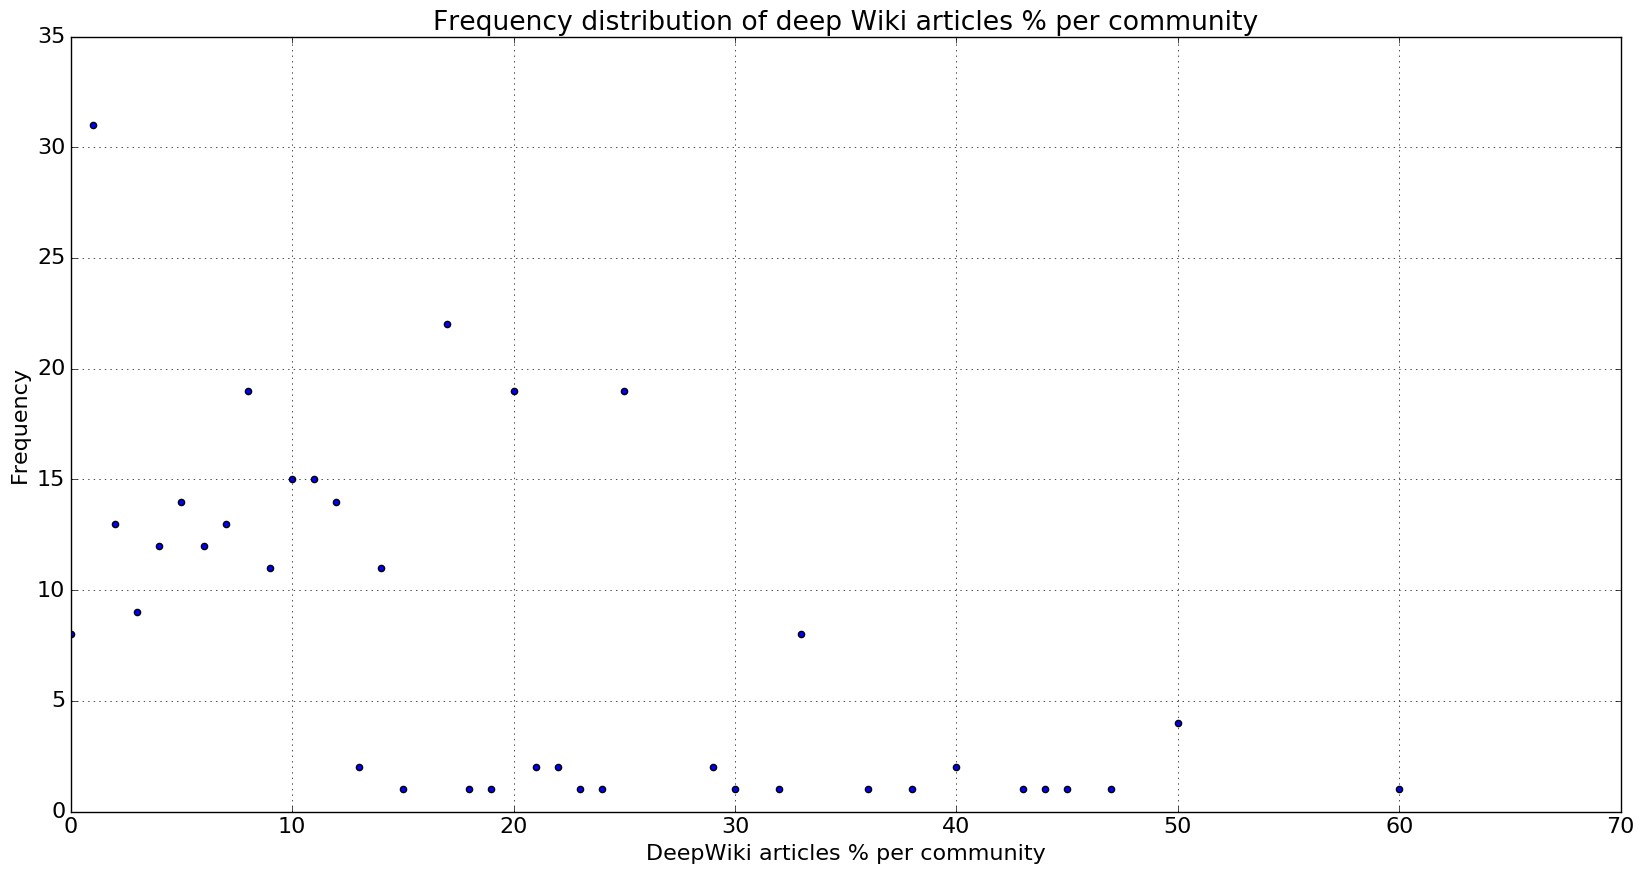

In [98]:
quick_plot(deep_wiki_pct_freq, "Frequency distribution of deep Wiki articles % per community")

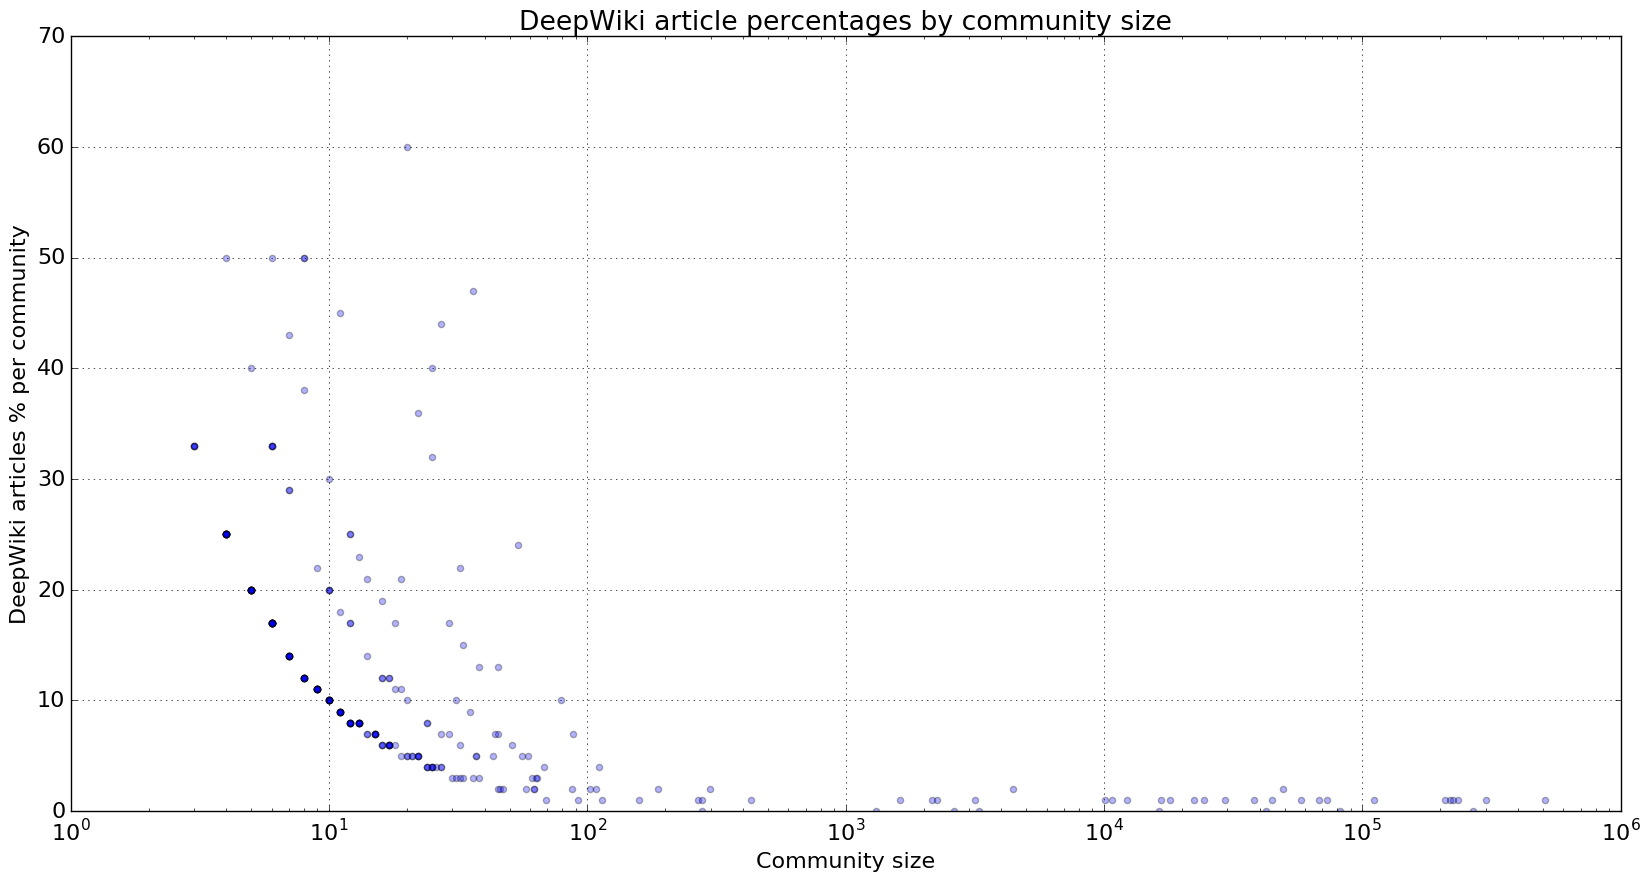

In [133]:
plt.scatter(community_deepWiki_stats.articles_count, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
#ax.set_xlim(xmin=0)
plt.xscale("log")

ax.set_ylim(ymin=0)
    
plt.xlabel('Community size')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community size");

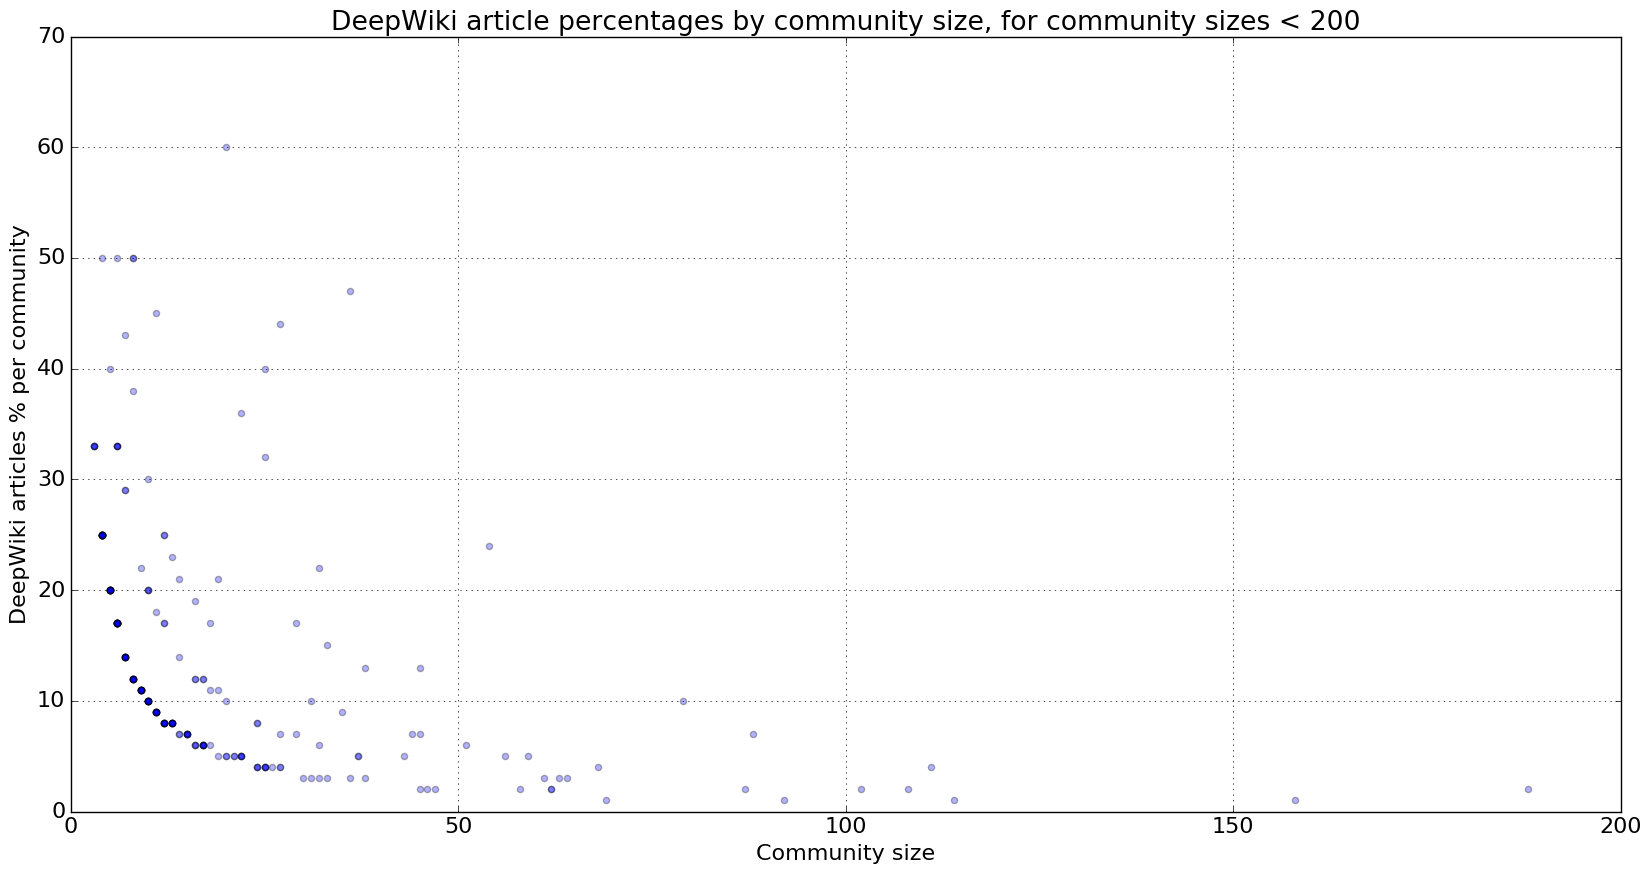

In [134]:
plt.scatter(community_deepWiki_stats.articles_count, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
ax.set_xlim(xmin=0, xmax=200)
ax.set_ylim(ymin=0)
    
plt.xlabel('Community size')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community size, for community sizes < 200");

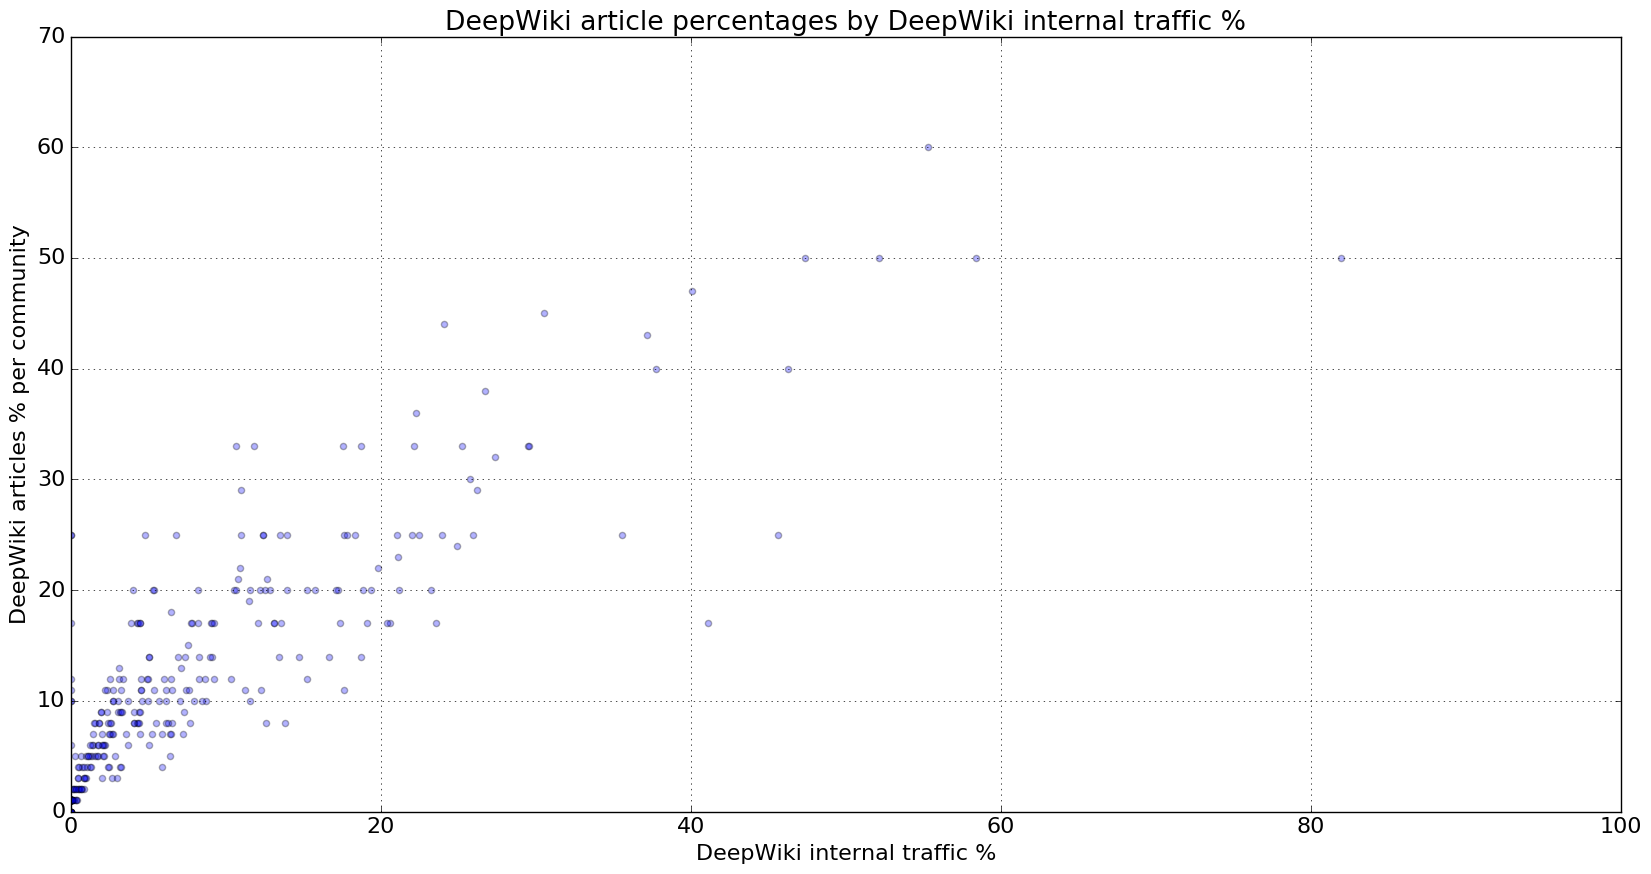

In [135]:
plt.scatter(community_deepWiki_stats.deep_wiki_internal_visits_proportion.round(6) * 100, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
    
plt.xlabel('DeepWiki internal traffic %')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by DeepWiki internal traffic %");

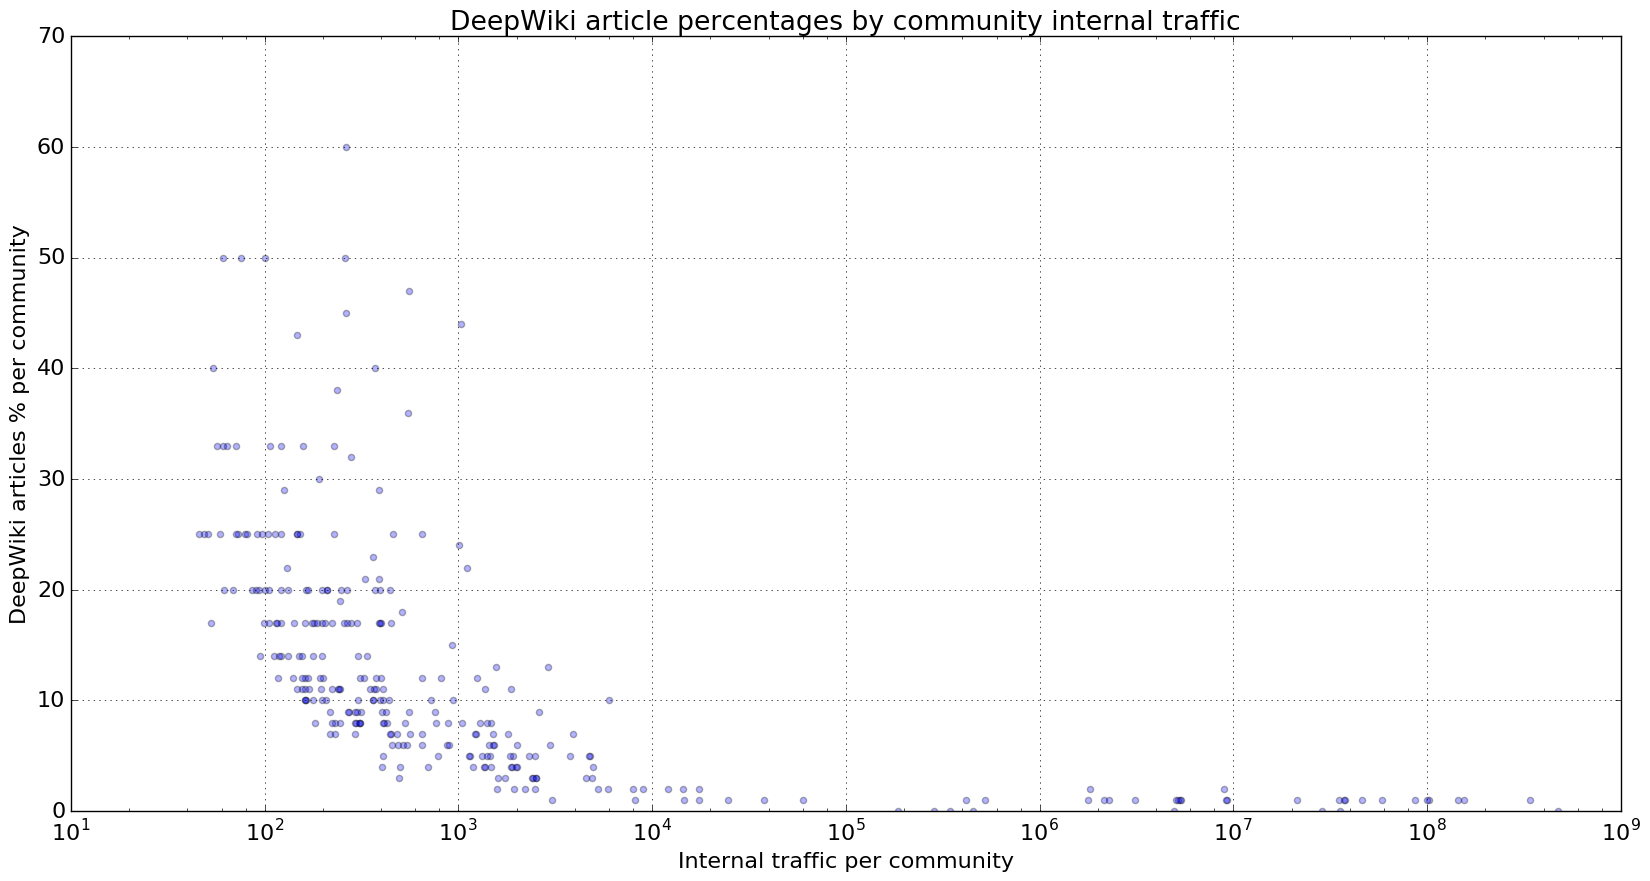

In [136]:
plt.scatter(community_deepWiki_stats.total_internal_visits, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
#ax.set_xlim(xmin=0)
plt.xscale("log")
ax.set_ylim(ymin=0)
   
plt.xlabel('Internal traffic per community')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community internal traffic");

In [172]:
# unpickle
with open("pickles/en_1218_louvain_communities.pkl", 'rb') as picklefile: 
    louvain_communities = pickle.load(picklefile)

louvain_communities.head()

,articles_count,external_search_traffic,link_edges_count,link_traffic,louvain_community,search_edges_count,search_traffic,total_visits,avg_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta,network_density,network_density_delta
0,507642,535227964,3385462,329625267,3,102124,4188154,1124655652,1054.34137443,97.36492892,2215.45036069,0.00001314,5.66900822,0.00002627,12.33801643
1,302120,288453340,2037310,140416238,7,41383,1257742,592415339,954.76413346,68.92237215,1960.86104528,0.00002232,5.74340243,0.00004464,12.48680487
2,267541,626988532,2540296,461475849,4,98857,3938984,1350876078,2343.52316841,181.66223503,5049.23012921,0.00003549,8.49501383,0.00007098,17.99002766
3,233396,150495954,1209989,84128861,10,25894,932688,322074785,644.80948260,69.52861638,1379.94989203,0.00002221,4.18429701,0.00004442,9.36859401
4,223864,219874886,1327054,151652674,5,32332,930331,468611692,982.18063646,114.27769631,2093.28740664,0.00002648,4.92797381,0.00005296,10.85594761


In [176]:
network_densities = louvain_communities[["louvain_community", "link_network_density", "link_network_density_delta",
                                            "network_density", "network_density_delta"]]
network_densities.set_index("louvain_community", inplace=True)

In [177]:
community_deepWiki_stats = community_deepWiki_stats.join(network_densities)

In [178]:
community_deepWiki_stats.head()

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,link_network_density,link_network_density_delta,network_density,network_density_delta
louvain_community,,,,,,,,,,,,,,,,
0,248,29397,0.00843623,3435,5306439,0.00064733,3414,5057107,0.00067509,21,29778,0.00070522,0.00014807,3.35287114,0.00029614,7.70574228
1,1099,218001,0.00504126,19950,101941984,0.00019570,19691,95420595,0.00020636,259,1056534,0.00024514,0.00003352,6.30755963,0.00006704,13.61511927
2,2423,209065,0.01158970,39438,100235624,0.00039345,38916,96546076,0.00040308,522,1568306,0.00033284,0.00003051,5.37907052,0.00006102,11.75814105
3,3860,507642,0.00760378,64629,339915502,0.00019013,62693,329625267,0.00019019,1916,4188154,0.00045748,0.00001314,5.66900822,0.00002627,12.33801643
4,1020,267541,0.00381250,18366,472694667,0.00003885,18132,461475849,0.00003929,234,3938984,0.00005941,0.00003549,8.49501383,0.00007098,17.99002766


In [182]:
community_deepWiki_stats[community_deepWiki_stats.network_density > 1]

,deep_wiki_articles_count,articles_count,deep_wiki_articles_proportion,deep_wiki_internal_visits,total_internal_visits,deep_wiki_internal_visits_proportion,deep_wiki_link_in_traffic,link_in_traffic,deep_wiki_link_in_traffic_proportion,deep_wiki_search_in_traffic,search_in_traffic,deep_wiki_search_in_traffic_proportion,link_network_density,link_network_density_delta,network_density,network_density_delta
louvain_community,,,,,,,,,,,,,,,,
817,1,3,0.33333333,18,61,0.29508197,18,61,0.29508197,0,0,nan,0.66666667,1.00000000,1.33333333,3.00000000
1207,1,3,0.33333333,13,122,0.10655738,13,122,0.10655738,0,0,nan,0.66666667,1.00000000,1.33333333,3.00000000


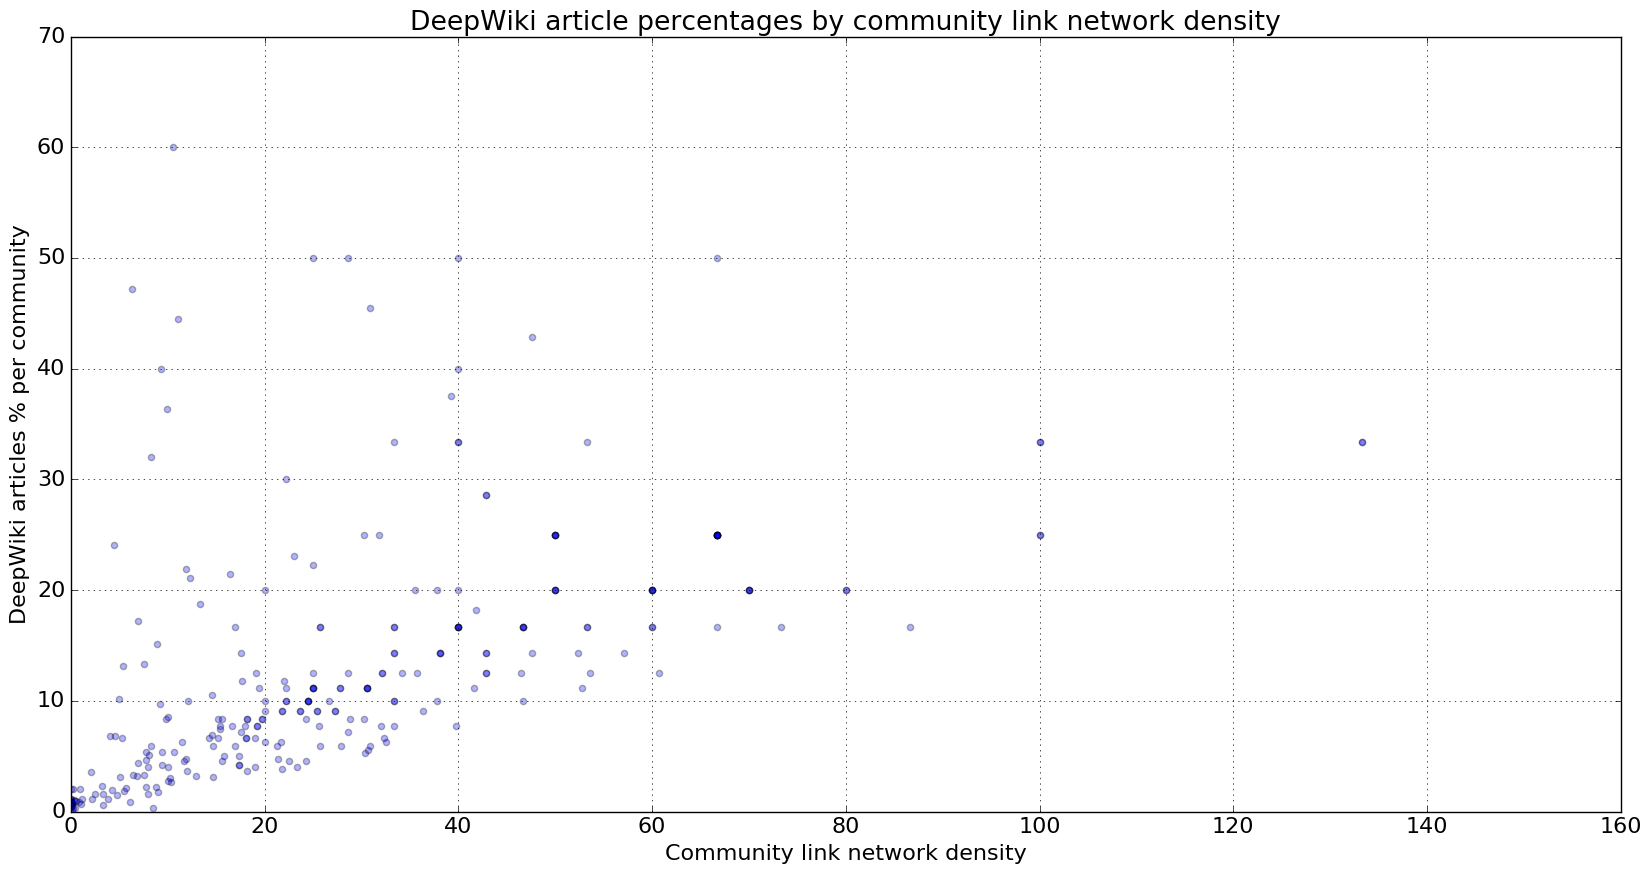

In [181]:
plt.scatter(community_deepWiki_stats.network_density.round(6) * 100, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(4) * 100, c="b", alpha=0.3)
ax = plt.gca()
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
    
plt.xlabel('Community link network density')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community link network density");

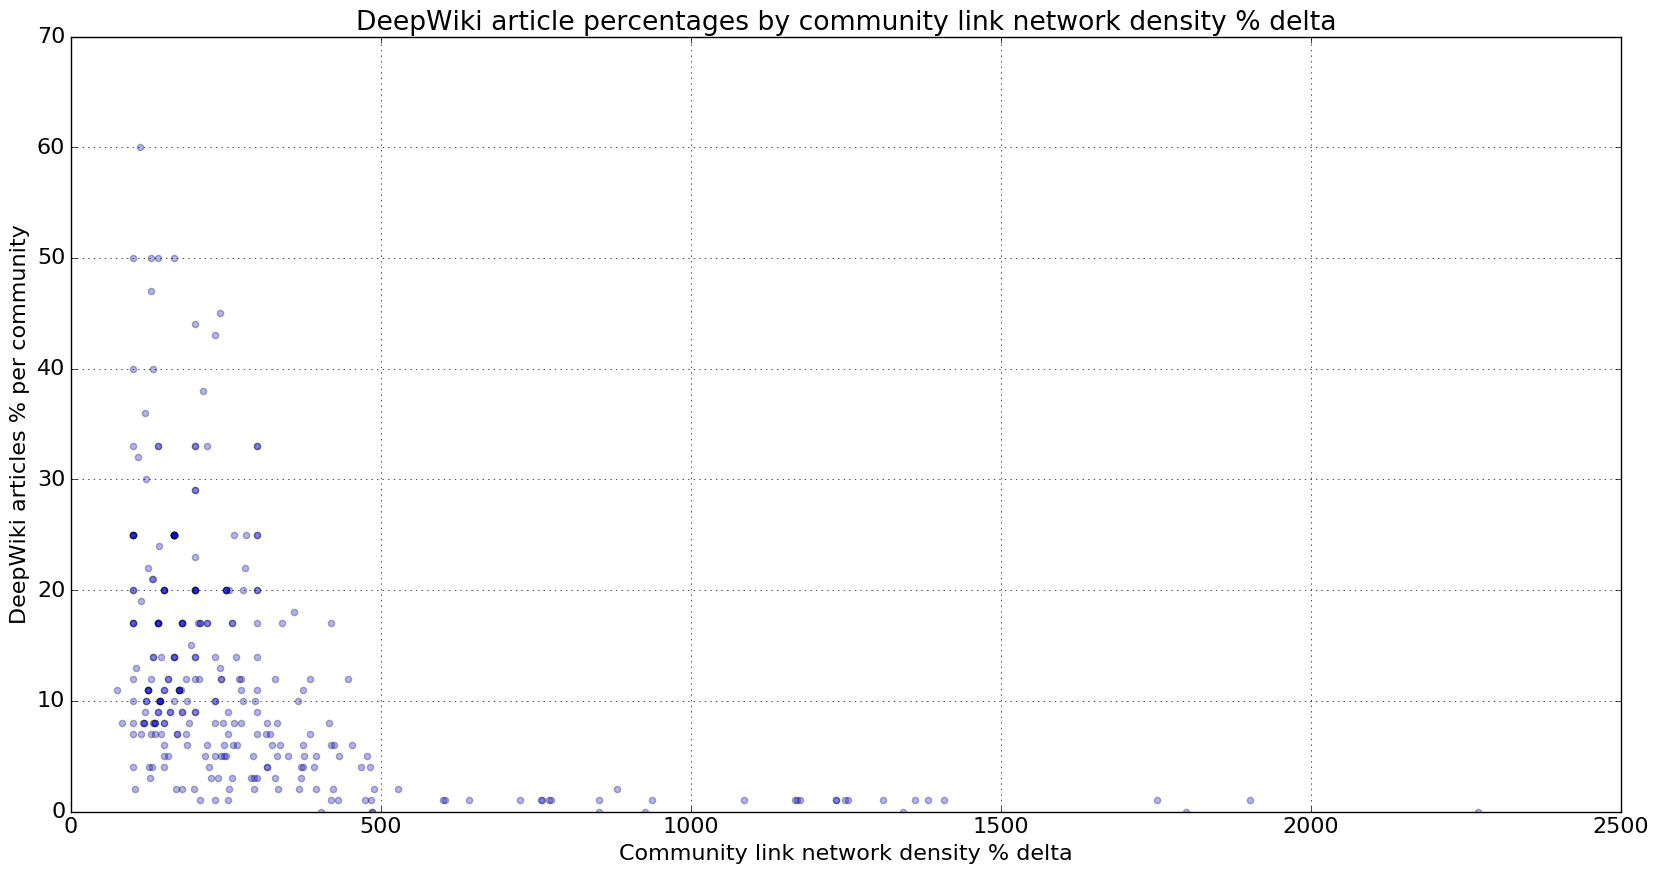

In [180]:
plt.scatter(community_deepWiki_stats.network_density_delta.round(2) * 100, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
    
plt.xlabel('Community link network density % delta')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community link network density % delta");

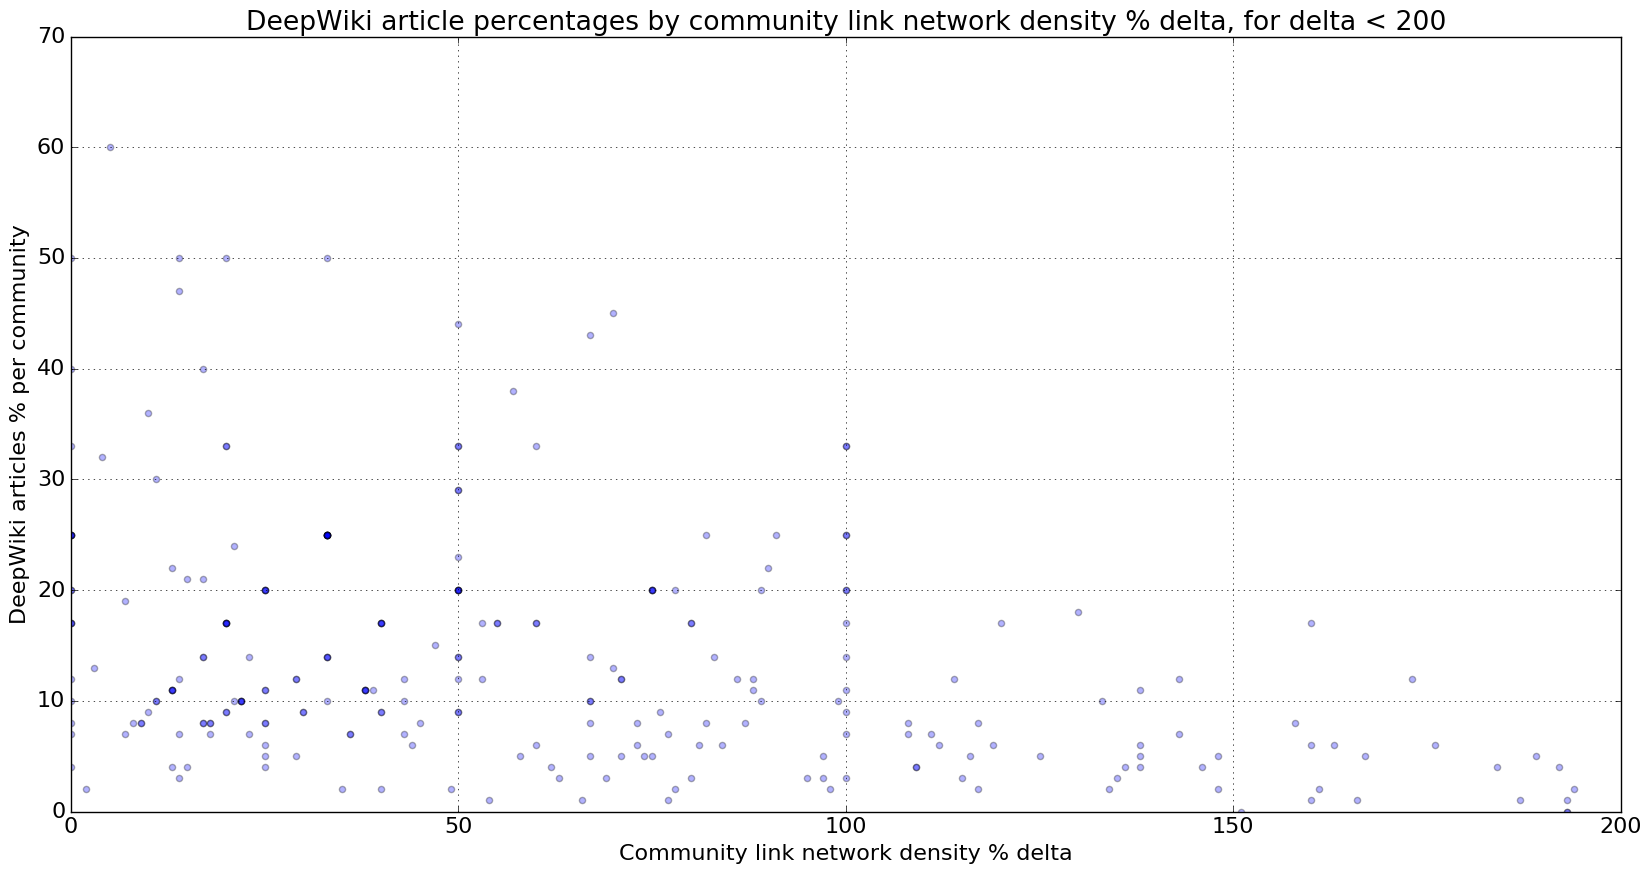

In [167]:
plt.scatter(community_deepWiki_stats.link_network_density_delta.round(2) * 100, 
            community_deepWiki_stats.deep_wiki_articles_proportion.round(2) * 100, c="b", alpha=0.3)
ax = plt.gca()
ax.set_xlim(xmin=0, xmax=200)
ax.set_ylim(ymin=0)
    
plt.xlabel('Community link network density % delta')
plt.ylabel('DeepWiki articles % per community')
plt.grid(True)
plt.title("DeepWiki article percentages by community link network density % delta, for delta < 200");

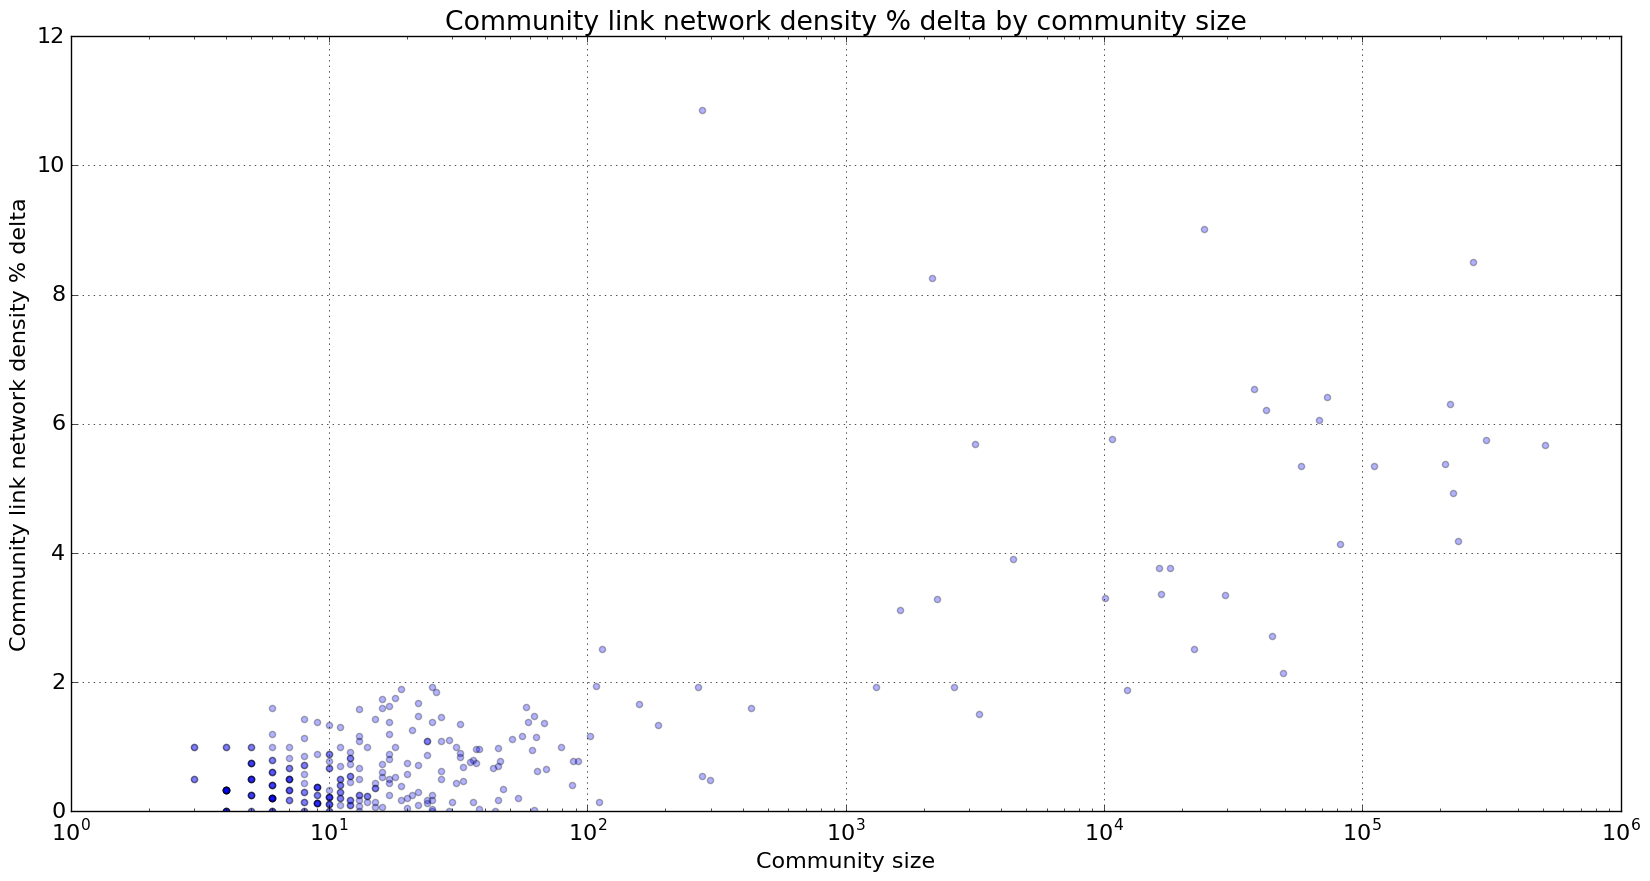

In [171]:
plt.scatter(community_deepWiki_stats.articles_count,
            community_deepWiki_stats.link_network_density_delta.round(2), c="b", alpha=0.3)
ax = plt.gca()
#ax.set_xlim(xmin=0)
plt.xscale("log")
ax.set_ylim(ymin=0)
    
plt.xlabel('Community size')
plt.ylabel('Community link network density % delta')
plt.grid(True)
plt.title("Community link network density % delta by community size");